# QBUS2820 Assignment 2

**SID:** 510575452

In [698]:
# Importing Relevant Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from forecast import histogram, qq_plot, intervalforecast,fanchart
from sklearn.metrics import mean_squared_error

# Executive Summary

The project requirements aims to develop a time series model to forecast the Consumer Price Index (CPI) using data given to us that consists of 100 entries ranging from quarterly periods from March 1997 to December 2021.  The main objective is to predict the CPI values for March 2022 to December 2023 using multiple-step-ahead approaches.  Having accurate CPI forecasts is essential for economic and financial decision making.  

# Loading in Dataset

## Raw Data

In [699]:
CPI_train_data = pd.read_csv('data/CPI_train.csv', index_col='Quarter')

CPI_train_data

,CPI
Quarter,
Mar-97,94.5
Jun-97,93.1
Sep-97,95.4
Dec-97,96.3
Mar-98,96.0
...,...
Dec-20,125.3
Mar-21,123.6
Jun-21,124.5


**Note:**

- There are 100 entries


- Shows each quarter from 1997 - 2021


- Date layout: <abbreviation_of_month>-yy

## Parsed Data

In [700]:
CPI_train_data.index = pd.to_datetime(
    CPI_train_data.index, format='%b-%y', errors='coerce')

CPI_train_data.index = CPI_train_data.index.to_period('Q')

CPI_train_data

,CPI
Quarter,
1997Q1,94.5
1997Q2,93.1
1997Q3,95.4
1997Q4,96.3
1998Q1,96.0
...,...
2020Q4,125.3
2021Q1,123.6
2021Q2,124.5


Data is parsed so that the index of `CPI_Train_data` is converted into a quarterly period index format instead of `<abbreviation_of_month>-yy` format.  This will make the analysis consistent with the data provided and easier to apply to time series related libraries.

# EDA

## Looking at Key Characteristics of the dataset

In [701]:
CPI_train_data.head()

,CPI
Quarter,
1997Q1,94.5
1997Q2,93.1
1997Q3,95.4
1997Q4,96.3
1998Q1,96.0


In [702]:
CPI_train_data.tail()

,CPI
Quarter,
2020Q4,125.3
2021Q1,123.6
2021Q2,124.5
2021Q3,126.2
2021Q4,125.8


In [703]:
CPI_train_data.columns

Index(['CPI'], dtype='object')

In [704]:
CPI_train_data.shape

(100, 1)

## Data Cleaning

### Removing null values

In [705]:
clean_CPI_train_data = CPI_train_data.dropna()

**Note:** even though there are no null values, it is great practice to always include this step in the data cleaning phase.

## Looking at the information of the dataset

In [706]:
clean_CPI_train_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 100 entries, 1997Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     100 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


## Looking at the description of the dataset

In [707]:
clean_CPI_train_data.describe()

,CPI
count,100.000000
mean,113.704000
std,9.187496
min,93.100000
25%,105.875000
50%,116.600000
75%,120.350000
max,126.200000


## Checking for Null Value

In [708]:
clean_CPI_train_data.isnull().sum()

CPI    0
dtype: int64

## Looking at the trend of the data

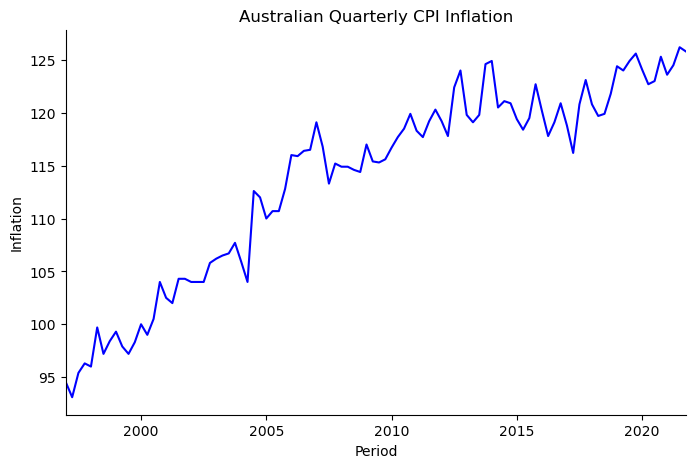

In [709]:
y = clean_CPI_train_data['CPI']

fig_CPI_trend, ax_CPI_trend = plt.subplots(figsize=(8, 5))
y.plot(color='b', ax=ax_CPI_trend)
ax_CPI_trend.set_xlabel('Period')
ax_CPI_trend.set_ylabel('Inflation')
ax_CPI_trend.set_title('Australian Quarterly CPI Inflation')
ax_CPI_trend.set_xticks([], minor=True)
sns.despine()
plt.show()

Based off the line graph for the Australian Quarterly CPI inflation, it shows a positive trend which indicates rise of prices overtime.  It also shows volatility of prices over the years but in particular in 2008, it shows the deflation of prices due to reduction in price of automative fuels (Treasury Ministers, 2021).

## Time Series Decomposition

In [710]:
window_size = 12    
decomposition = seasonal_decompose(y, model='additive', period=4, filt=np.repeat(1/window_size, window_size))

In [711]:
decomposition.seasonal.tail()

Quarter
2020Q4    0.894602
2021Q1    0.243466
2021Q2   -0.937595
2021Q3   -0.200473
2021Q4    0.894602
Freq: Q-DEC, Name: seasonal, dtype: float64

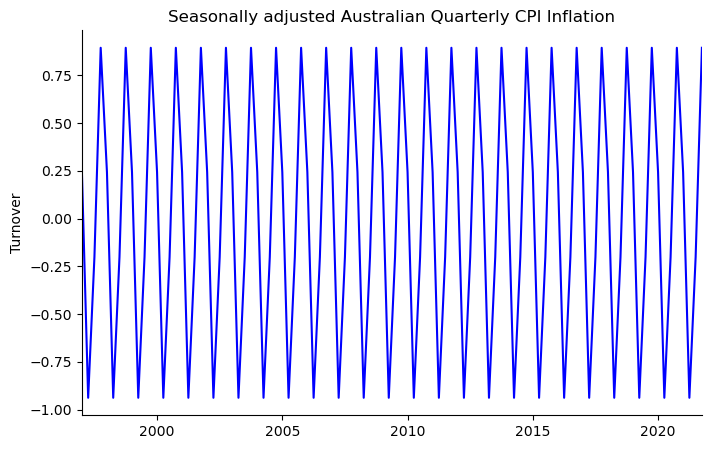

In [712]:
fig_seasonal_decomposition, ax_seasonal_decomposition = plt.subplots(
    figsize=(8, 5))
decomposition.seasonal.plot(color='blue', ax=ax_seasonal_decomposition)
ax_seasonal_decomposition.set_xlabel('')
ax_seasonal_decomposition.set_ylabel('Turnover')
ax_seasonal_decomposition.set_title(
    'Seasonally adjusted Australian Quarterly CPI Inflation')
ax_seasonal_decomposition.set_xticks([], minor=True)
sns.despine()
plt.show()

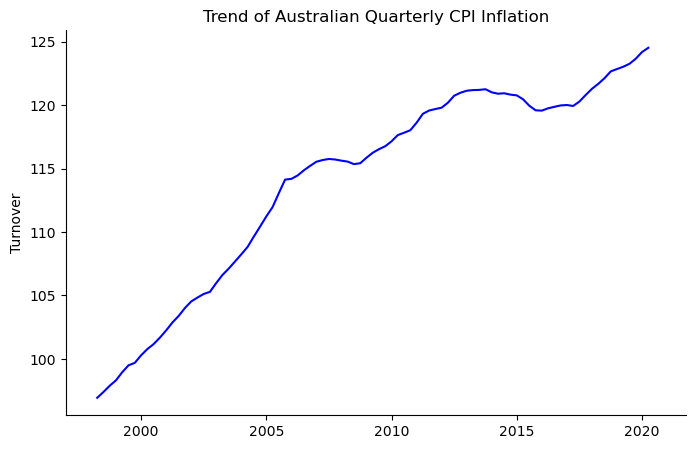

In [713]:
fig_trend_decomposition, ax_trend_decomposition = plt.subplots(figsize=(8, 5))
decomposition.trend.plot(color="blue", ax=ax_trend_decomposition)
ax_trend_decomposition.set_xlabel('')
ax_trend_decomposition.set_ylabel('Turnover')
ax_trend_decomposition.set_title('Trend of Australian Quarterly CPI Inflation')
ax_trend_decomposition.set_xticks([], minor=True)
sns.despine()
plt.show()

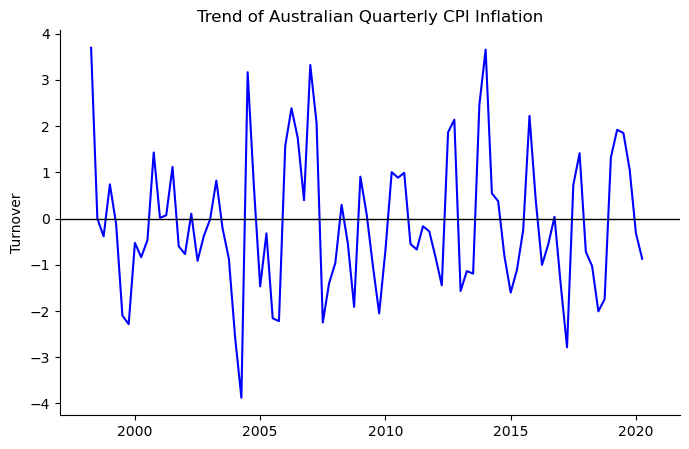

In [714]:
fig_resid_decomposition, ax_resid_decomposition = plt.subplots(figsize=(8, 5))
decomposition.resid.plot(color='blue', ax=ax_resid_decomposition)
ax_resid_decomposition.axhline(0, color='black', lw=1)
ax_resid_decomposition.set_xlabel('')
ax_resid_decomposition.set_ylabel('Turnover')
ax_resid_decomposition.set_title('Trend of Australian Quarterly CPI Inflation')
ax_resid_decomposition.set_xticks([], minor=True)
sns.despine()
plt.show()

## Testing for Stationary Points

**Hypothesis Testing** using **Augmented Dickey-Fuller**

**Formula:** 

\begin{align*}
\boldsymbol{\Delta} y_t = \boldsymbol{\alpha} + \boldsymbol{\beta} t + \boldsymbol{\gamma} y_{t-1} + \boldsymbol{\delta}_1 \boldsymbol{\Delta} y_{t-1} \dots + \boldsymbol{\delta}_{p-1} \boldsymbol{\Delta} y_{t-p+1} + \boldsymbol{\epsilon}_t,
\end{align*}


where $\boldsymbol{\alpha}$ is a constant term,  $\boldsymbol{\beta} t$ is the trend coefficient, $\boldsymbol{\gamma} y_{t-1}$ is the coefficient of the lagged level of time series, $\boldsymbol{\delta}_i$ are the coefficients of the lagged differences, $t$ is the time index, $p$ is the number of lags, and $\boldsymbol{\epsilon}_t$ is the error term  

$\boldsymbol{H_0}:$ The time series is non-stationary.


$\boldsymbol{H_A}:$ The time series is stationary.


**Threshold:**


$\boldsymbol{\alpha} = 0.05$

In [715]:
adf_test = adfuller(CPI_train_data['CPI'], autolag='t-stat')
print(f'ADF P-value: {round(adf_test[1], 4)}')

ADF P-value: 0.212


Since the p-value $> 0.05$ ($\alpha$), we fail to reject the null hypothesis which suggests that the time series is non-stationary.  Hence, we will be using model smoothing to forecast the future predictions of the Australian CPI Inflation. 

# Model Smoothing

## Simple Exponential Smoothing 

In [716]:
simple_exponential_smoothing = SimpleExpSmoothing(y, initialization_method="estimated")
fitted_simple_exponential_smoothing = simple_exponential_smoothing.fit(optimized=True)
fitted_simple_exponential_smoothing.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,SimpleExpSmoothing,SSE,388.993
Optimized:,True,AIC,139.839
Trend:,None,BIC,145.049
Seasonal:,None,AICC,140.260
Seasonal Periods:,None,Date:,"Tue, 22 Oct 2024"
Box-Cox:,False,Time:,13:43:54
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6496116,alpha,True
initial_level,94.341806,l.0,True


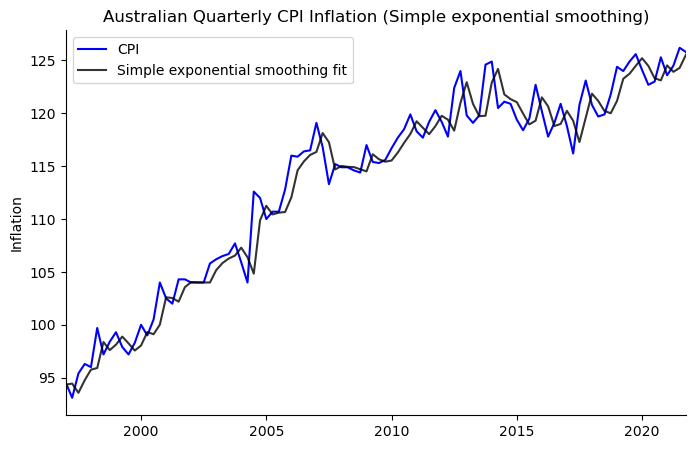

In [717]:
fig_simple_exponential_smoothing, ax_simple_exponential_smoothing = plt.subplots(
    figsize=(8, 5))
y.plot(color='blue', ax=ax_simple_exponential_smoothing)
simple_exponential_smoothing_fitted = fitted_simple_exponential_smoothing.fittedvalues
simple_exponential_smoothing_fitted.plot(
    color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax_simple_exponential_smoothing.set_xlabel('')
ax_simple_exponential_smoothing.set_ylabel('Inflation')
ax_simple_exponential_smoothing.set_title(
    'Australian Quarterly CPI Inflation (Simple exponential smoothing)')
ax_simple_exponential_smoothing.set_xticks([], minor=True)
plt.legend(loc='best')
sns.despine()
plt.show()

### Model Diagnostics

#### Residual Plot

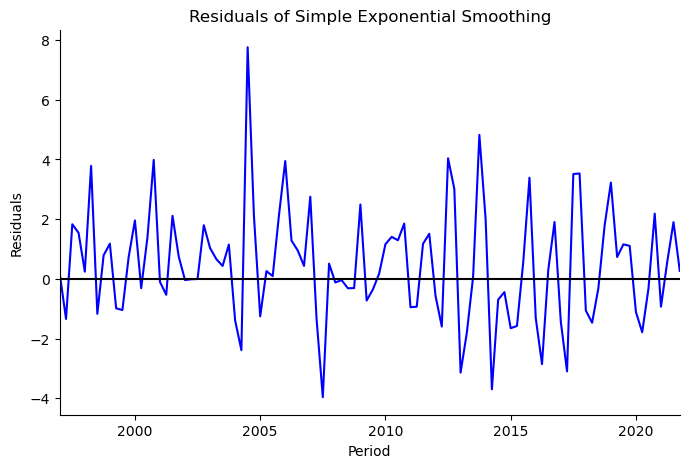

In [718]:
simple_exponential_smoothing_resid = y-simple_exponential_smoothing_fitted

fig_resid_simple_exponential_smoothing, ax_simple_exponential_smoothing = plt.subplots(
    figsize=(8, 5))
simple_exponential_smoothing_resid.plot(
    color='b', ax=ax_simple_exponential_smoothing)
ax_simple_exponential_smoothing.set_xlabel('Period')
ax_simple_exponential_smoothing.set_ylabel('Residuals')
ax_simple_exponential_smoothing.set_title(
    'Residuals of Simple Exponential Smoothing')
ax_simple_exponential_smoothing.set_xticks([], minor=True)
sns.despine()
plt.axhline(0, color='black')
plt.show()

#### Autocorrelation Plot

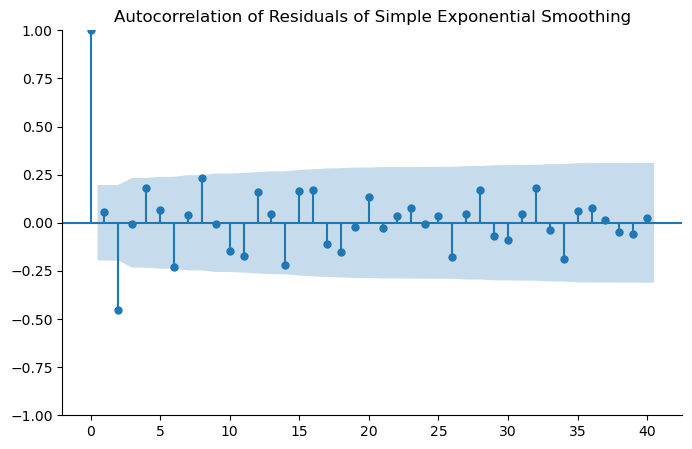

In [719]:
fig_acf_simple_exponential_smoothing, ax_acf_simple_exponential_smoothing = plt.subplots(
    figsize=(8, 5))
sm.graphics.tsa.plot_acf(simple_exponential_smoothing_resid,
                         lags=40, ax=ax_acf_simple_exponential_smoothing, alpha=0.05)
sns.despine()
plt.title('Autocorrelation of Residuals of Simple Exponential Smoothing')
plt.show()

#### Histogram Plot

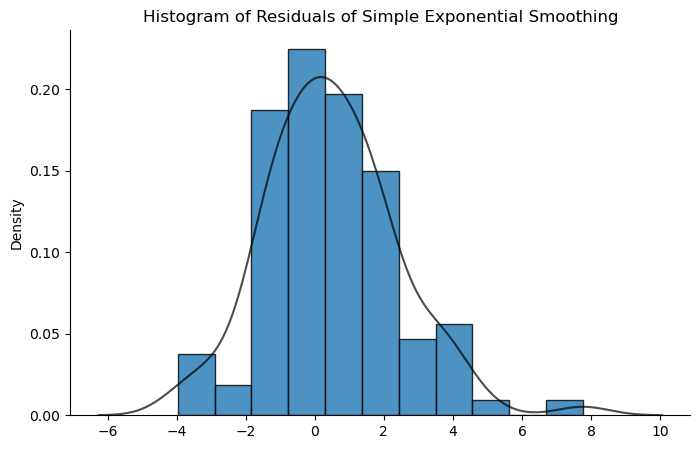

In [720]:
histogram(simple_exponential_smoothing_resid)
plt.title('Histogram of Residuals of Simple Exponential Smoothing')
plt.show()

#### QQ-plot

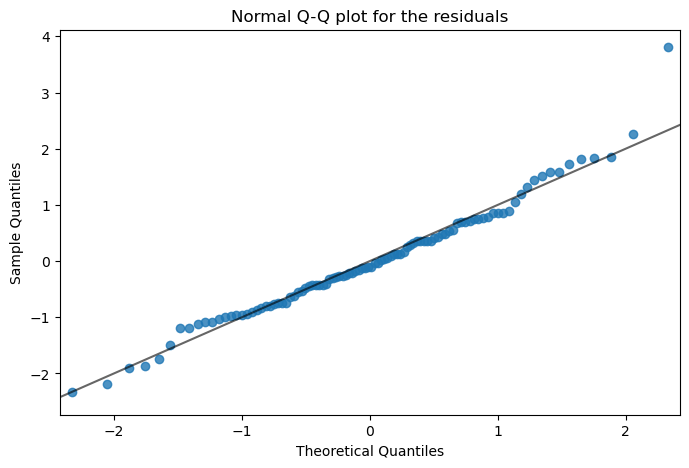

In [721]:
qq_plot(simple_exponential_smoothing_resid)
plt.show()

### Forecast

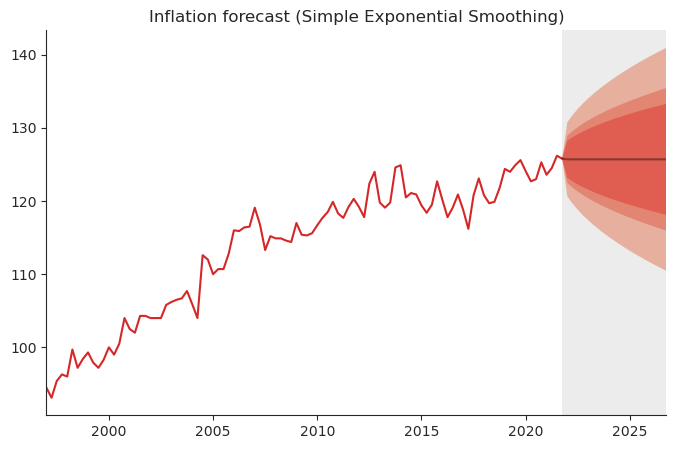

In [722]:
horizon = 20

test = pd.period_range(
    start=y.index[-1] + 1, periods=horizon, freq='Q')

pred = pd.Series(
    fitted_simple_exponential_smoothing.forecast(horizon), index=test)

intv1 = pd.DataFrame(intervalforecast(
    fitted_simple_exponential_smoothing, horizon, level=.8), index=test)
intv2 = pd.DataFrame(intervalforecast(
    fitted_simple_exponential_smoothing, horizon, level=.9), index=test)
intv3 = pd.DataFrame(intervalforecast(
    fitted_simple_exponential_smoothing, horizon, level=.99), index=test)

fig_forecast_simple_exponential_smoothing, ax_forecast_simple_exponential_smoothing = fanchart(
    y, pred, intv1, intv2, intv3)
ax_forecast_simple_exponential_smoothing.set_xlabel('')
ax_forecast_simple_exponential_smoothing.set_xticks([], minor=True)
plt.title('Inflation forecast (Simple Exponential Smoothing)')

sns.despine()
plt.show()

## Holt Exponential Smoothing

In [723]:
holt_exponential_smoothing = Holt(y, initialization_method="estimated")
fitted_holt_exponential_smoothing = holt_exponential_smoothing.fit(optimized=True)
fitted_holt_exponential_smoothing.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,Holt,SSE,357.486
Optimized:,True,AIC,135.393
Trend:,Additive,BIC,145.813
Seasonal:,None,AICC,136.296
Seasonal Periods:,None,Date:,"Tue, 22 Oct 2024"
Box-Cox:,False,Time:,13:43:55
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4700246,alpha,True
smoothing_trend,0.000000,beta,True


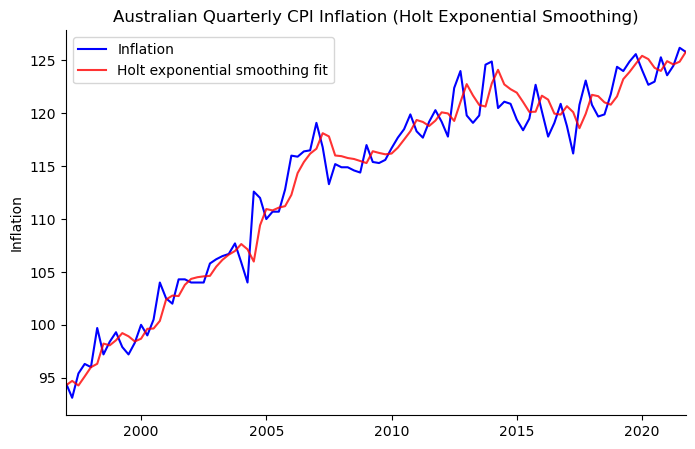

In [724]:
fig_holt_exponential_smoothing, ax_holt_exponential_smoothing = plt.subplots(
    figsize=(8, 5))
y.plot(color='b', label='Inflation')
holt_exponential_smoothing_resid_fitted = fitted_holt_exponential_smoothing.fittedvalues
holt_exponential_smoothing_resid_fitted.plot(color='red', label='Holt exponential smoothing fit', alpha=0.8)
ax_holt_exponential_smoothing.set_xlabel('')
ax_holt_exponential_smoothing.set_ylabel('Inflation')
ax_holt_exponential_smoothing.set_title(
    'Australian Quarterly CPI Inflation (Holt Exponential Smoothing)')
ax_holt_exponential_smoothing.set_xticks([], minor=True)
plt.legend(loc='best')
sns.despine()
plt.show()

### Model Diagnostics

#### Residual Plot

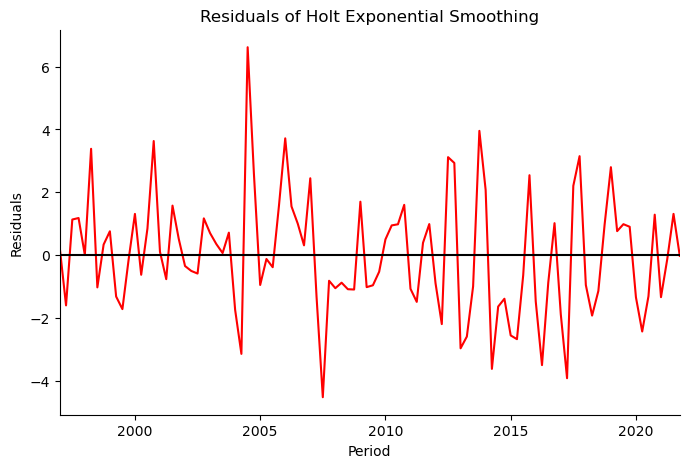

In [725]:
holt_exponential_smoothing_resid = y-holt_exponential_smoothing_resid_fitted

fig_resid_holt_exponential_smoothing, ax_resid_holt_exponential_smoothing = plt.subplots(
    figsize=(8, 5))
holt_exponential_smoothing_resid.plot(
    color='red', ax=ax_resid_holt_exponential_smoothing)
ax_resid_holt_exponential_smoothing.set_xlabel('Period')
ax_resid_holt_exponential_smoothing.set_ylabel('Residuals')
ax_resid_holt_exponential_smoothing.set_title(
    'Residuals of Holt Exponential Smoothing')
ax_resid_holt_exponential_smoothing.set_xticks([], minor=True)
sns.despine()
plt.axhline(0, color='black')
plt.show()

#### Autocorrelation Plot

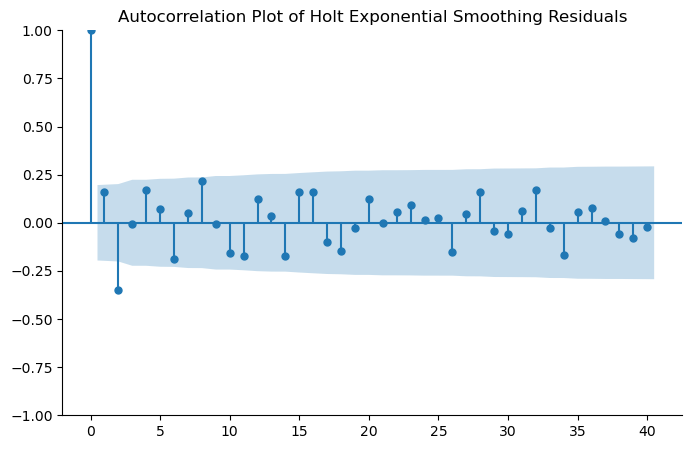

In [726]:
fig_acf_holt_exponential_smoothing, ax_acf_holt_exponential_smoothing = plt.subplots(
    figsize=(8, 5))
sm.graphics.tsa.plot_acf(holt_exponential_smoothing_resid,
                         lags=40, ax=ax_acf_holt_exponential_smoothing, alpha=0.05)
sns.despine()
plt.title('Autocorrelation Plot of Holt Exponential Smoothing Residuals')
plt.show()

#### Histogram Plot

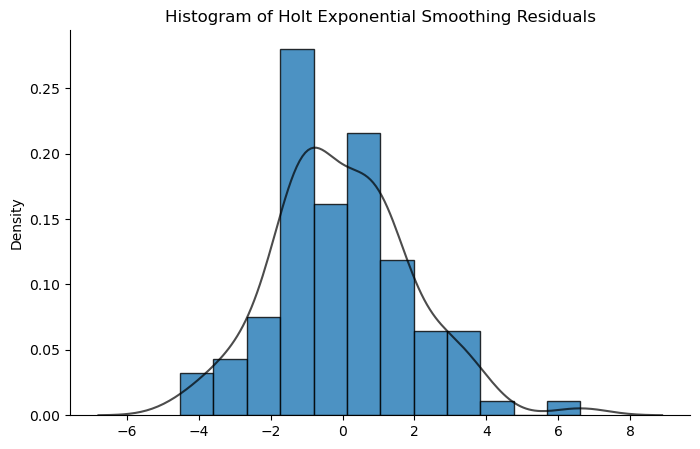

In [727]:
histogram(holt_exponential_smoothing_resid)
plt.title('Histogram of Holt Exponential Smoothing Residuals')
plt.show()

#### QQ-plot

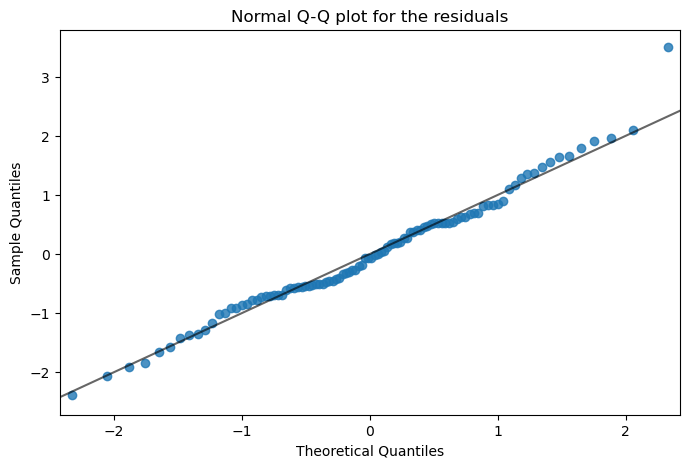

In [728]:
qq_plot(holt_exponential_smoothing_resid)
plt.show()

### Forecast

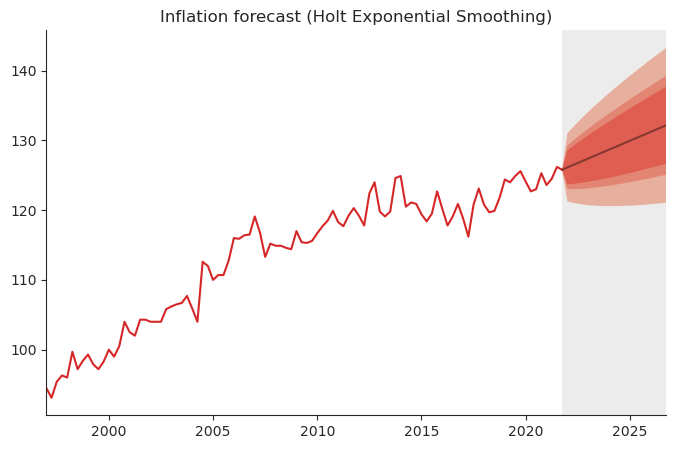

In [729]:
horizon = 20

test = pd.period_range(
    start=y.index[-1] + 1, periods=horizon, freq='Q')

pred = pd.Series(
    fitted_holt_exponential_smoothing.forecast(horizon), index=test)

intv1 = pd.DataFrame(intervalforecast(
    fitted_holt_exponential_smoothing, horizon, level=.8), index=test)
intv2 = pd.DataFrame(intervalforecast(
    fitted_holt_exponential_smoothing, horizon, level=.9), index=test)
intv3 = pd.DataFrame(intervalforecast(
    fitted_holt_exponential_smoothing, horizon, level=.99), index=test)

fig_forecast_holt_exponential_smoothing, ax_forecast_holt_exponential_smoothing = fanchart(
    y, pred, intv1, intv2, intv3)
ax_forecast_holt_exponential_smoothing.set_xlabel('')
ax_forecast_holt_exponential_smoothing.set_xticks([], minor=True)
plt.title('Inflation forecast (Holt Exponential Smoothing)')

sns.despine()
plt.show()

## Holt-Winters Exponential Smoothing

In [730]:
ahw=ExponentialSmoothing(y, seasonal_periods=4, trend="add", seasonal="add", initialization_method="estimated").fit()
ahw.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,ExponentialSmoothing,SSE,291.201
Optimized:,True,AIC,122.884
Trend:,Additive,BIC,143.726
Seasonal:,Additive,AICC,125.356
Seasonal Periods:,4,Date:,"Tue, 22 Oct 2024"
Box-Cox:,False,Time:,13:43:56
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5691148,alpha,True
smoothing_trend,4.7635e-10,beta,True


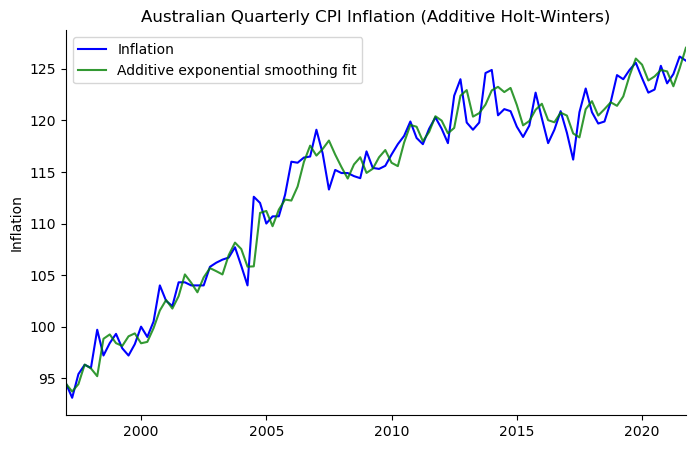

In [746]:
fig_ahw, ax_ahw = plt.subplots(figsize=(8, 5))
y.plot(color='b', label='Inflation')
ahw_fitted = ahw.fittedvalues
ahw_fitted.plot(
    color='green', label='Additive exponential smoothing fit', alpha=0.8)
ax_ahw.set_xlabel('')
ax_ahw.set_ylabel('Inflation')
ax_ahw.set_title(
    'Australian Quarterly CPI Inflation (Additive Holt-Winters)')
ax_ahw.set_xticks([], minor=True)
plt.legend(loc='best')
sns.despine()
plt.show()

### Model Diagnostic

#### Residual Plot

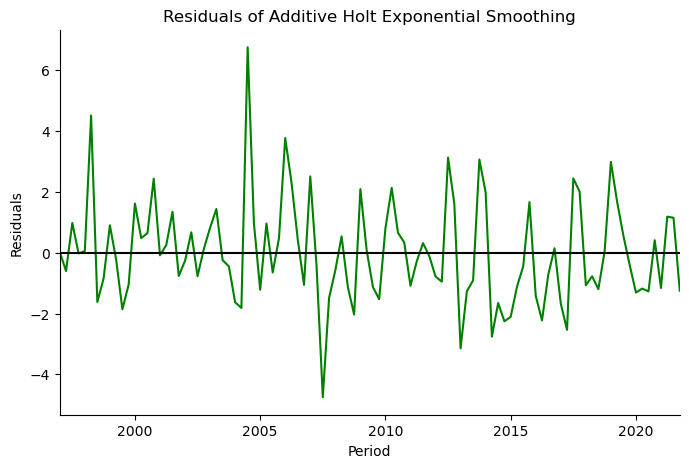

In [745]:
ahw_resid = y-ahw_fitted

fig_resid_ahw, ax_resid_ahw = plt.subplots(figsize=(8, 5))
ahw_resid.plot(color='green', ax=ax_resid_ahw)
ax_resid_ahw.set_xlabel('Period')
ax_resid_ahw.set_ylabel('Residuals')
ax_resid_ahw.set_title('Residuals of Additive Holt Exponential Smoothing')
ax_resid_ahw.set_xticks([], minor=True)
sns.despine()
plt.axhline(0, color='black')
plt.show()

#### Autocorrelation Plot

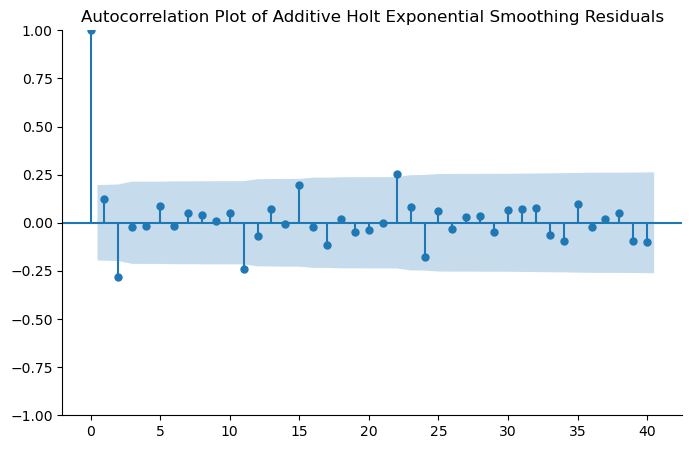

In [742]:
fig_acf_ahw, ax_acf_ahw = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_acf(ahw_resid, lags=40, ax=ax_acf_ahw, alpha=0.05)
sns.despine()
plt.title('Autocorrelation Plot of Additive Holt Exponential Smoothing Residuals')
plt.show()

#### Histogram Plot

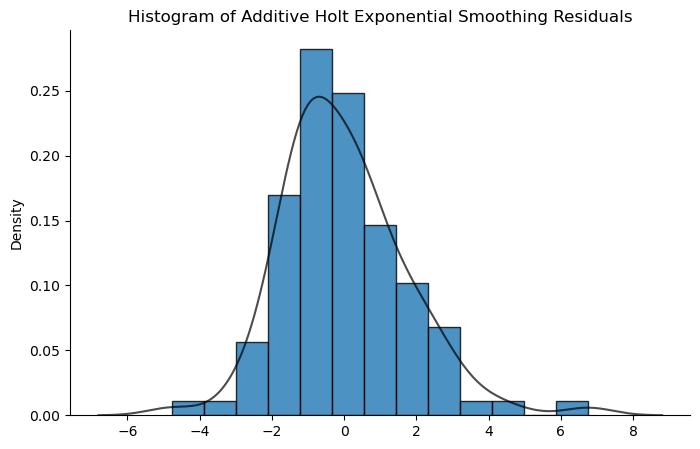

In [743]:
histogram(ahw_resid)
plt.title('Histogram of Additive Holt Exponential Smoothing Residuals')
plt.show()

#### QQ-plot

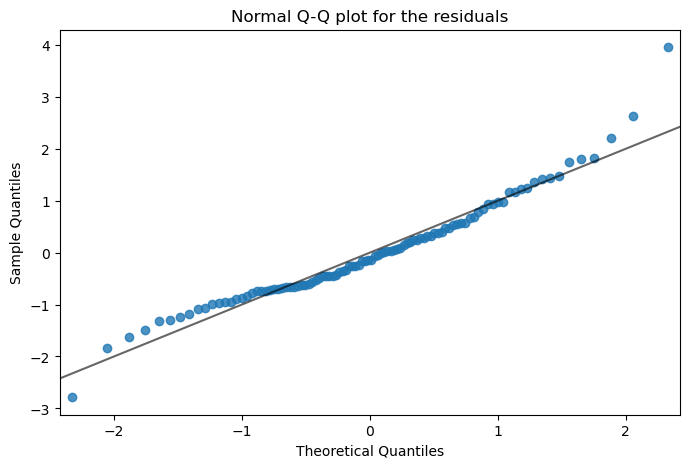

In [735]:
qq_plot(ahw_resid)
plt.show()

### Forecast

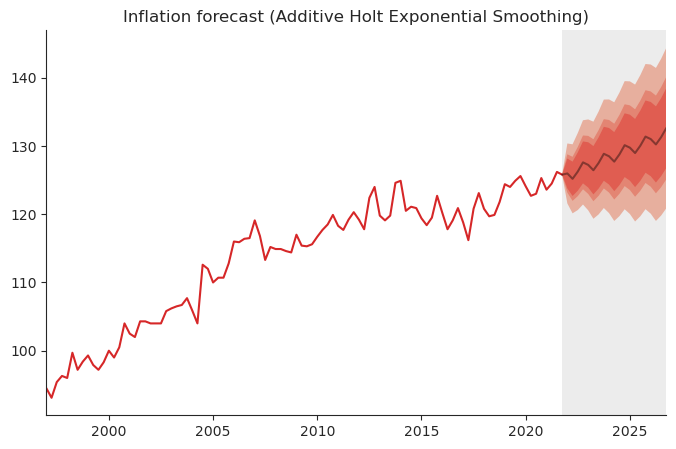

In [744]:
horizon = 20

test = pd.period_range(
    start=y.index[-1] + 1, periods=horizon, freq='Q')

pred = pd.Series(
    ahw.forecast(horizon), index=test)

intv1 = pd.DataFrame(intervalforecast(
    ahw, horizon, level=.8), index=test)
intv2 = pd.DataFrame(intervalforecast(
    ahw, horizon, level=.9), index=test)
intv3 = pd.DataFrame(intervalforecast(
    ahw, horizon, level=.99), index=test)

fig_forecast_ahw, ax_forecast_ahw = fanchart(y, pred, intv1, intv2, intv3)
ax_forecast_ahw.set_xlabel('')
ax_forecast_ahw.set_xticks([], minor=True)
plt.title('Inflation forecast (Additive Holt Exponential Smoothing)')

sns.despine()
plt.show()

### Plotting Smoothing Model Forecasts

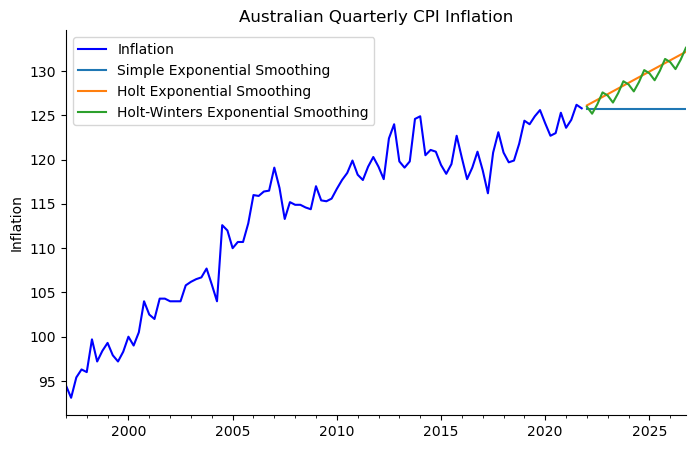

In [737]:
# Plot the predictions of all the smoothing models with the validation set

smoothing_models = [fitted_simple_exponential_smoothing,
                    fitted_holt_exponential_smoothing, ahw]

model_names = ['Simple Exponential Smoothing',
               'Holt Exponential Smoothing', 'Additive Holt-Winters Exponential Smoothing']

fig_comparison, ax_comparison = plt.subplots(figsize=(8, 5))
y.plot(color='b', label='Inflation')
for i, model in enumerate(smoothing_models):
    pred = model.forecast(horizon)
    pred.plot(label=model_names[i])
ax_comparison.set_xlabel('')
ax_comparison.set_ylabel('Inflation')
ax_comparison.set_title('Australian Quarterly CPI Inflation')
plt.legend(loc='best')
sns.despine()
plt.show()

## Model Training

### Splitting Data into Training and Validation Sets

In [738]:
X = clean_CPI_train_data.drop('CPI', axis=1)
y = clean_CPI_train_data['CPI']

tss = TimeSeriesSplit(n_splits=3)

for train_index, val_index in tss.split(X):
    X_train, X_val = X.iloc[train_index, :], X.iloc[val_index, :]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [739]:
# Simple Exponential Smoothing
simple_exponential_smoothing = SimpleExpSmoothing(
    y_train, initialization_method="estimated")

fitted_simple_exponential_smoothing = simple_exponential_smoothing.fit(
    optimized=True)

# Holt Exponential Smoothing
holt_exponential_smoothing = Holt(
    y_train, initialization_method="estimated")

fitted_holt_exponential_smoothing = holt_exponential_smoothing.fit(
    optimized=True)

# Holt-Winters Exponential Smoothing
ahw = ExponentialSmoothing(
    y_train, seasonal_periods=4, trend="add", seasonal="add", initialization_method="estimated").fit()

# Calculate MSE

# Simple Exponential Smoothing
y_pred = fitted_simple_exponential_smoothing.forecast(len(y_val))
mse_simple_exponential_smoothing = mean_squared_error(y_val, y_pred).round(4)

# Holt Exponential Smoothing
y_pred = fitted_holt_exponential_smoothing.forecast(len(y_val))
mse_holt_exponential_smoothing = mean_squared_error(y_val, y_pred).round(4)

# Holt-Winters Exponential Smoothing
y_pred = ahw.forecast(len(y_val))
mse_ahw = mean_squared_error(y_val, y_pred).round(4)

# Create a dataframe to store the MSE of all the models
mse = pd.DataFrame({'Smoothing Model': ['Simple Exponential Smoothing',
                              'Holt Exponential Smoothing', 'Holt-Winters Exponential Smoothing'],
                    'MSE': [mse_simple_exponential_smoothing, mse_holt_exponential_smoothing, mse_ahw]})

mse.index = mse.index + 1

mse

,Smoothing Model,MSE
1,Simple Exponential Smoothing,15.6437
2,Holt Exponential Smoothing,7.1916
3,Holt-Winters Exponential Smoothing,7.0358


# Picking Best Smoothing Model

In [740]:
ahw = ExponentialSmoothing(y, seasonal_periods=4, trend="add", seasonal="add", initialization_method="estimated").fit()

horizon = 8

test = pd.period_range(
    start=y.index[-1] + 1, periods=horizon, freq='Q')

pred = pd.Series(
    ahw.forecast(horizon), index=test).round(4)


CPI_forecast = pd.DataFrame(pred, columns=['CPI'])
CPI_forecast.index.name = 'Quarter'
CPI_forecast.to_csv('CPI_forecast.csv')

CPI_forecast

,CPI
Quarter,
2022Q1,125.9747
2022Q2,125.1907
2022Q3,126.2547
2022Q4,127.5986
2023Q1,127.2346
2023Q2,126.4506
2023Q3,127.5146
2023Q4,128.8586


# Code Chunk to Run Tests for Predictions

In [741]:
# CPI_test = pd.read_csv('CPI_test.csv')
# test_error = mean_squared_error(CPI_test['CPI'], CPI_forecast['CPI'])
# print (test_error)

# References

Treasury Ministers (2021) December 2008 Consumer Price Index, December 2008 Consumer Price Index | Treasury Ministers. Treasury Ministers. Available at: https://ministers.treasury.gov.au/ministers/wayne-swan-2007/media-releases/december-2008-consumer-price-index#:~:text=The%20fall%20in%20the%20December,the%20latter%20part%20of%202008. (Accessed: 22 October 2024).